In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [6]:
#applying normalization with mnist mean and std 
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)


train_loader = DataLoader(mnist_train, batch_size=len(mnist_train), shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=False)


X_train, y_train = next(iter(train_loader))
X_test, y_test = next(iter(test_loader))


X_train = X_train.view(X_train.shape[0], -1).numpy()
X_test = X_test.view(X_test.shape[0], -1).numpy()
y_train = y_train.numpy()
y_test = y_test.numpy()

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.93      0.93      0.93       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.92      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.93      0.92     10000



/home/danial/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


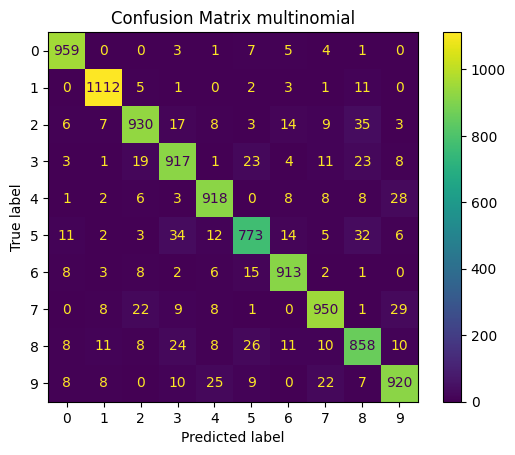

In [7]:
cm=confusion_matrix(y_pred=y_pred, y_true=y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1,2,3,4,5,6,7,8,9])
disp.plot()
plt.title("Confusion Matrix multinomial")
plt.show()

In [8]:
import numpy as np

def softmax(s):
    exp_s = np.exp(s - np.max(s, axis=1, keepdims=True))  # Stability fix by subtracting max value
    return exp_s / np.sum(exp_s, axis=1, keepdims=True)

class MultiLogisticRegression:
    def __init__(self, reg='l2', lr=0.01, num_iter=100, lambda_=0.001):
        self.lr = lr
        self.num_iter = num_iter
        self.regularization=reg
        self.lambda_ = lambda_
    
    def fit(self, X, y):
        X_with_bias = np.hstack((np.ones((X.shape[0], 1)), X)) 
        n_classes = len(np.unique(y))
        self.weights = np.zeros((X_with_bias.shape[1], n_classes))
        

        y_onehot = np.eye(n_classes)[y]        
        
        for i in range(self.num_iter):
            y_pred = softmax(X_with_bias @ self.weights)
            dw = X_with_bias.T @ (y_pred - y_onehot) / X.shape[0]

            if self.regularization=='l1':
                dw += self.lambda_ * np.sign(self.weights)
            else:
                dw+=(2 * self.lambda_ * self.weights)
            self.weights -= self.lr * dw


            if i % 20 == 0:
                current_loss = -np.mean(np.sum(y_onehot * np.log(y_pred + 1e-15), axis=1)+np.sum(self.weights**2))  
                # cross_entropy_loss = -np.mean(np.sum(y_onehot * np.log(y_pred + 1e-15), axis=1))
                true_class_indices = np.argmax(y_onehot, axis=1)
                cross_entropy_loss = -np.mean(np.log(y_pred[np.arange(y_onehot.shape[0]), true_class_indices]+ 1e-15))
                regularization_term = np.sum(self.weights**2)
                current_loss = cross_entropy_loss + self.lambda_*regularization_term
                print(f"Iteration {i}, Loss: {current_loss}")
    
    def predict(self, X):
        X_with_bias = np.hstack((np.ones((X.shape[0], 1)), X))
        linear_output = np.dot(X_with_bias, self.weights)
        y_pred = softmax(linear_output)
        return np.argmax(y_pred, axis=1)


In [11]:
from sklearn.model_selection import KFold

model = MultiLogisticRegression()#multinomial log regression
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

results = [] 
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    model.fit(X_train_fold, y_train_fold) 
    y_pred_fold = model.predict(X_test_fold)
    f1 = f1_score(y_test_fold, y_pred_fold, average='micro')
    results.append(f1)
    print(f"Fold f1_score: {f1}")
average_f1 = np.mean(results)
print(f"Average f1_score: {average_f1:.4f}")


model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
report = classification_report(y_test, y_test_pred, target_names=[str(i) for i in range(10)])
print("Classification Report:\n", report)

Iteration 0, Loss: 2.3025862518995
Iteration 20, Loss: 1.1412333782531774
Iteration 40, Loss: 0.8414559856621535
Iteration 60, Loss: 0.7107897665163461
Iteration 80, Loss: 0.6364876610023195
Fold f1_score: 0.8629166666666667
Iteration 0, Loss: 2.3025862496903597
Iteration 20, Loss: 1.140945059829209
Iteration 40, Loss: 0.8413400841128096
Iteration 60, Loss: 0.7108069447205887
Iteration 80, Loss: 0.6365512112876163
Fold f1_score: 0.8655
Iteration 0, Loss: 2.3025862517512508
Iteration 20, Loss: 1.140306888549243
Iteration 40, Loss: 0.8402873955116444
Iteration 60, Loss: 0.709415141495391
Iteration 80, Loss: 0.6348932150736757
Fold f1_score: 0.8613333333333333
Iteration 0, Loss: 2.302586245215431
Iteration 20, Loss: 1.1422860465940397
Iteration 40, Loss: 0.8417451323880064
Iteration 60, Loss: 0.7106766889757649
Iteration 80, Loss: 0.63608714839527
Fold f1_score: 0.8650833333333333
Iteration 0, Loss: 2.3025862490675477
Iteration 20, Loss: 1.1416783246933222
Iteration 40, Loss: 0.8414823256

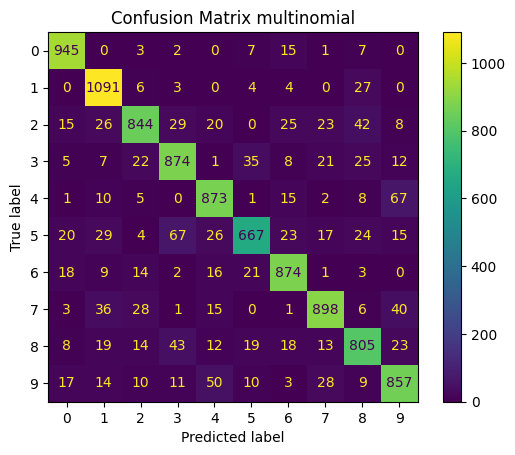

In [34]:
cm=confusion_matrix(y_pred=y_test_pred, y_true=y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1,2,3,4,5,6,7,8,9])
disp.plot()
plt.title("Confusion Matrix multinomial")
plt.show()

In [7]:
def plot_predictions(X, y_true, y_pred, title, num_samples=10):
    idx = np.where(y_true == y_pred)[0] if title == "Correct Predictions" else np.where(y_true != y_pred)[0]
    samples = np.random.choice(idx, num_samples, replace=False)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(X[samples[i]].reshape(28, 28), cmap="gray")
        ax.set_title(f"True: {y_true[samples[i]]}\nPred: {y_pred[samples[i]]}")
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

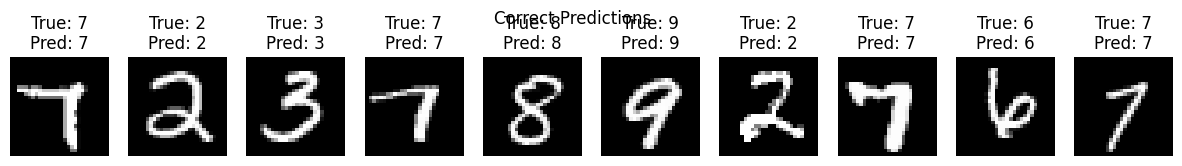

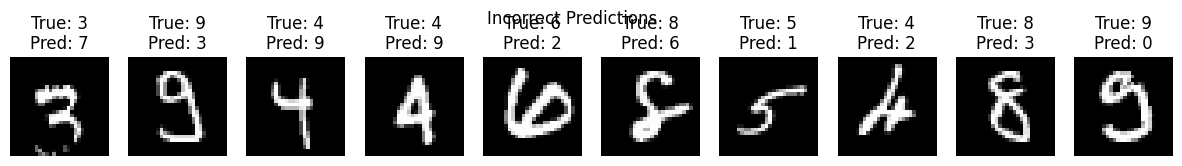

In [8]:
plot_predictions(X_test, y_test, y_test_pred, "Correct Predictions")
plot_predictions(X_test, y_test, y_test_pred, "Incorrect Predictions")

In [9]:
import numpy as np

def sigmoid(s):
    s = np.clip(s, -500, 500)  # Avoid overflow
    return 1 / (1 + np.exp(-s))

class Log_Reg:
    def __init__(self, lr=0.001, num_iter=100,lambda_=0.001):
        self.lr = lr
        self.num_iter = num_iter
        self.lambda_=lambda_
    def fit(self, X, y):
        X_with_bias = np.hstack((np.ones((X.shape[0], 1)), X)) 
        self.weights = np.zeros((X_with_bias.shape[1], 1))
        y = y.reshape(-1, 1)
        for i in range(self.num_iter):
            dw = np.mean((-y * X_with_bias).T @ sigmoid(-y * np.dot(X_with_bias, self.weights)), axis=1) 
            dw=dw.reshape(-1, 1)
            # dw+=(2 * self.lambda_ * self.weights)
            dw += self.lambda_ * np.sign(self.weights)
            self.weights = self.weights - dw.reshape(-1, 1) * self.lr
            
            if i % 50 == 0:
                current_loss = np.mean(np.log(1/sigmoid(X_with_bias @ self.weights * y)))+self.lambda_*np.sum(self.weights**2)
                print(f"Iteration {i},  Loss: {current_loss}")
    
    def predict(self, X):
        X_with_bias = np.hstack((np.ones((X.shape[0], 1)), X))
        linear_output = np.dot(X_with_bias, self.weights)
        y_pred = sigmoid(linear_output)
        return y_pred
    

In [10]:
#one-vs-all approach

classes = np.unique(y_train)
n_classes = len(classes)


classifiers = []
for class_id in classes:
    y_binary = np.where(y_train == class_id, 1, -1)
    clf = Log_Reg()
    clf.fit(X_train, y_binary)
    classifiers.append(clf)


def predict_multiclass(X, classifiers):
    predictions = np.array([clf.predict(X) for clf in classifiers])
    return np.argmax(predictions, axis=0)

y_pred = predict_multiclass(X_test, classifiers)

Iteration 0,  Loss: 186.19249928005448
Iteration 50,  Loss: 54.737187446148724
Iteration 0,  Loss: 207.12752985243586
Iteration 50,  Loss: 74.30503837461865
Iteration 0,  Loss: 183.5100691430371
Iteration 50,  Loss: 54.7734933233735
Iteration 0,  Loss: 181.42873541128392
Iteration 50,  Loss: 74.6901198568847
Iteration 0,  Loss: 189.17892028188993
Iteration 50,  Loss: 51.429464723009005
Iteration 0,  Loss: 187.7851789166267
Iteration 50,  Loss: 76.34439424778614
Iteration 0,  Loss: 184.66504881242116
Iteration 50,  Loss: 38.0185807586677
Iteration 0,  Loss: 192.43681826693486
Iteration 50,  Loss: 39.66199882715116
Iteration 0,  Loss: 170.50334677560505
Iteration 50,  Loss: 136.0258904097917
Iteration 0,  Loss: 181.31724504740362
Iteration 50,  Loss: 133.42413851345543


In [12]:
report = classification_report(y_true=y_test, y_pred=y_pred, target_names=[str(i) for i in range(10)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87       980
           1       0.94      0.98      0.96      1135
           2       0.83      0.91      0.87      1032
           3       0.76      0.93      0.84      1010
           4       0.75      0.95      0.84       982
           5       0.97      0.59      0.73       892
           6       0.84      0.94      0.88       958
           7       0.97      0.78      0.86      1028
           8       0.92      0.72      0.81       974
           9       0.92      0.70      0.80      1009

    accuracy                           0.85     10000
   macro avg       0.87      0.85      0.85     10000
weighted avg       0.87      0.85      0.85     10000



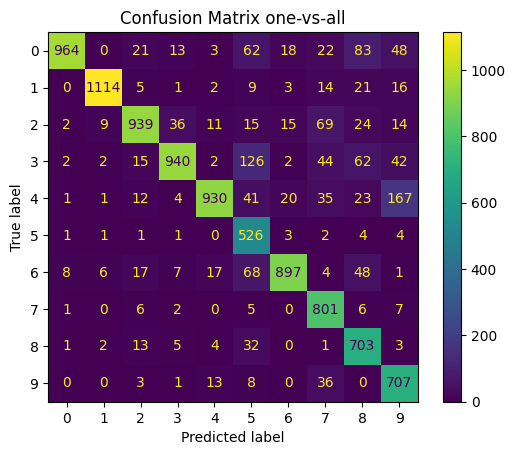

In [13]:
cm=confusion_matrix(y_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1,2,3,4,5,6,7,8,9])
disp.plot()
plt.title("Confusion Matrix one-vs-all")
plt.show()

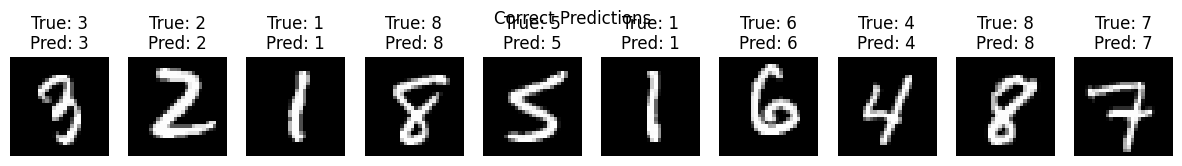

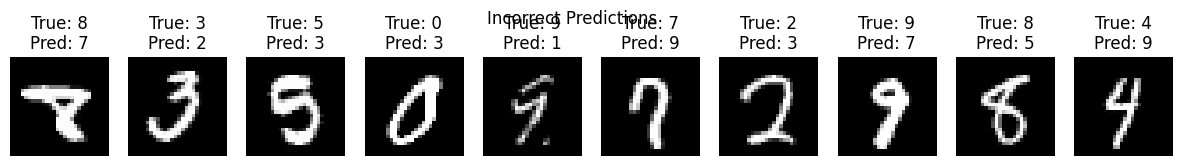

In [14]:
plot_predictions(X_test, y_test, y_test_pred, "Correct Predictions")
plot_predictions(X_test, y_test, y_test_pred, "Incorrect Predictions")

In [20]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import numpy as np
from scipy.optimize import minimize

class MultiClassSVM:
    def __init__(self, C=1.0, kernel="linear", gamma=0.1):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.classifiers = {}
        self.classes = None

    def _train_binary_svm(self, X, y, positive_class):
        y_binary = np.where(y == positive_class, 1, -1)

        svm = SVM(C=self.C, kernel=self.kernel, gamma=self.gamma)
        svm.fit(X, y_binary)
        return svm

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            # Train one-vs-all classifier for each class
            print("Starting doing", cls)
            self.classifiers[cls] = self._train_binary_svm(X, y, cls)

    def predict(self, X):
        decision_functions = {cls: clf.predict(X) for cls, clf in self.classifiers.items()}
        predictions = np.array([decision_functions[cls] for cls in self.classes])
        return self.classes[np.argmax(predictions, axis=0)]

class SVM:
    def __init__(self, C=1.0, kernel="linear", gamma=0.1):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.alpha = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.support_alpha = None
        self.b = 0

    def linear_kernel(self, x1, x2):
        return np.dot(x1, x2)

    def rbf_kernel(self, x1, x2):
        return np.exp(-self.gamma * np.linalg.norm(x1 - x2)**2)

    def compute_kernel(self, X):
        n_samples = X.shape[0]
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                if self.kernel == "linear":
                    K[i, j] = self.linear_kernel(X[i], X[j])
                elif self.kernel == "rbf":
                    K[i, j] = self.rbf_kernel(X[i], X[j])
        return K

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = y.astype(np.float64)

        K = self.compute_kernel(X)

        def objective(alpha):
            return 0.5 * np.sum(alpha * alpha[:, None] * y * y[:, None] * K) - np.sum(alpha)

        constraints = [{"type": "eq", "fun": lambda alpha: np.dot(alpha, y)},
                       {"type": "ineq", "fun": lambda alpha: self.C - alpha},
                       {"type": "ineq", "fun": lambda alpha: alpha}]

        alpha_init = np.zeros(n_samples)
        print("Starting to optimize for the given class")

        with tqdm(total=n_samples, desc="Training SVM") as pbar:
          result = minimize(objective, alpha_init, constraints=constraints, method="SLSQP", callback=lambda x: pbar.update(1))
          self.alpha = result.x

        sv = self.alpha > 1e-5
        self.support_vectors = X[sv]
        self.support_vector_labels = y[sv]
        self.support_alpha = self.alpha[sv]

        # Calculate the intercept b
        self.b = np.mean(self.support_vector_labels - np.sum(self.support_alpha * self.support_vector_labels * K[sv][:, sv], axis=1))

    def predict(self, X):
        if self.kernel == "linear":
            decision_function = np.sum(self.support_alpha * self.support_vector_labels *
                                       np.dot(X, self.support_vectors.T), axis=1) + self.b
        elif self.kernel == "rbf":
            decision_function = np.sum([self.support_alpha[i] * self.support_vector_labels[i] *
                                        np.exp(-self.gamma * np.linalg.norm(X - sv, axis=1)**2)
                                        for i, sv in enumerate(self.support_vectors)], axis=0) + self.b
        return decision_function


def cross_validate(X, y, kernel="linear", C_values=[1.0], gamma_values=[0.1], k_folds=5):
    best_score = 0
    best_params = {}

    for C in C_values:
        for gamma in gamma_values:
            scores = []
            kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                # Instantiate a multi-class SVM using one-vs-all approach
                multi_svm = MultiClassSVM(C=C, kernel=kernel, gamma=gamma)
                multi_svm.fit(X_train, y_train)
                y_pred = multi_svm.predict(X_val)
                scores.append(accuracy_score(y_val, y_pred))

            avg_score = np.mean(scores)
            if avg_score > best_score:
                best_score = avg_score
                best_params = {"C": C, "gamma": gamma}

    return best_params, best_score


In [35]:
import numpy as np

# Convert dataset to flattened format for SVM input
def preprocess_data(dataset):
    data = dataset.data.numpy().reshape(len(dataset), -1) / 255.0  # Normalize to [0, 1]
    targets = dataset.targets.numpy()
    return data, targets

X_train, y_train = preprocess_data(mnist_train)
X_test, y_test = preprocess_data(mnist_test)

X_train, y_train = X_train[: 600], y_train[:600]
X_test, y_test = X_test[:100], y_test[:100]

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (600, 784)
Test data shape: (100, 784)


In [36]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Cross-validation for SVM parametersdef cross_validate(X, y, kernel="linear", C_values=[1.0], gamma_values=[0.1], k_folds=5):

def cross_validate(X, y, kernel="linear", C_values=[1.0], gamma_values=[0.1], k_folds=2): # change k_folds to 5
    best_score = 0
    best_params = {}

    for C in C_values:
        for gamma in gamma_values:
            scores = []
            kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                # Instantiate a multi-class SVM using one-vs-all approach
                multi_svm = MultiClassSVM(C=C, kernel=kernel, gamma=gamma)
                multi_svm.fit(X_train, y_train)
                y_pred = multi_svm.predict(X_val)
                scores.append(accuracy_score(y_val, y_pred))

            avg_score = np.mean(scores)
            if avg_score > best_score:
                best_score = avg_score
                best_params = {"C": C, "gamma": gamma}

    return best_params, best_score

# best_params, best_score = cross_validate(X_train, y_train, kernel="rbf", C_values=[0.1, 1, 10], gamma_values=[0.01, 0.1, 1])
best_params, best_score = cross_validate(X_train, y_train, kernel="rbf", C_values=[1], gamma_values=[0.1])
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Starting doing 0
Starting to optimize for the given class


Training SVM:   3%|▎         | 9/300 [00:01<00:33,  8.74it/s]


Starting doing 1
Starting to optimize for the given class


Training SVM:   4%|▎         | 11/300 [00:01<00:29,  9.85it/s]


Starting doing 2
Starting to optimize for the given class


Training SVM:   3%|▎         | 10/300 [00:01<00:31,  9.11it/s]


Starting doing 3
Starting to optimize for the given class


Training SVM:   3%|▎         | 9/300 [00:01<00:32,  8.97it/s]


Starting doing 4
Starting to optimize for the given class


Training SVM:   3%|▎         | 10/300 [00:01<00:31,  9.31it/s]


Starting doing 5
Starting to optimize for the given class


Training SVM:   3%|▎         | 10/300 [00:01<00:30,  9.53it/s]


Starting doing 6
Starting to optimize for the given class


Training SVM:   3%|▎         | 9/300 [00:00<00:31,  9.35it/s]


Starting doing 7
Starting to optimize for the given class


Training SVM:   3%|▎         | 9/300 [00:01<00:33,  8.77it/s]


Starting doing 8
Starting to optimize for the given class


Training SVM:   3%|▎         | 9/300 [00:00<00:31,  9.35it/s]


Starting doing 9
Starting to optimize for the given class


Training SVM:   3%|▎         | 9/300 [00:00<00:30,  9.60it/s]


Starting doing 0
Starting to optimize for the given class


Training SVM:   3%|▎         | 10/300 [00:01<00:29,  9.78it/s]


Starting doing 1
Starting to optimize for the given class


Training SVM:   4%|▍         | 13/300 [00:01<00:27, 10.45it/s]


Starting doing 2
Starting to optimize for the given class


Training SVM:   3%|▎         | 10/300 [00:01<00:30,  9.41it/s]


Starting doing 3
Starting to optimize for the given class


Training SVM:   3%|▎         | 10/300 [00:01<00:30,  9.43it/s]


Starting doing 4
Starting to optimize for the given class


Training SVM:   3%|▎         | 8/300 [00:00<00:31,  9.24it/s]


Starting doing 5
Starting to optimize for the given class


Training SVM:   3%|▎         | 9/300 [00:00<00:30,  9.40it/s]


Starting doing 6
Starting to optimize for the given class


Training SVM:   3%|▎         | 9/300 [00:00<00:31,  9.12it/s]


Starting doing 7
Starting to optimize for the given class


Training SVM:   3%|▎         | 10/300 [00:01<00:31,  9.31it/s]


Starting doing 8
Starting to optimize for the given class


Training SVM:   3%|▎         | 9/300 [00:00<00:31,  9.20it/s]


Starting doing 9
Starting to optimize for the given class


Training SVM:   3%|▎         | 10/300 [00:01<00:33,  8.76it/s]


Best Parameters: {'C': 1, 'gamma': 0.1}
Best Cross-Validation Score: 0.7033333333333334


In [37]:
multi_svm = MultiClassSVM(C=best_params["C"], kernel="rbf", gamma=best_params["gamma"])
multi_svm.fit(X_train, y_train)

# Predictions on test set
y_test_pred = multi_svm.predict(X_test)

Starting doing 0
Starting to optimize for the given class


Training SVM:   2%|▏         | 13/600 [00:10<08:00,  1.22it/s]


Starting doing 1
Starting to optimize for the given class


Training SVM:   2%|▏         | 14/600 [00:10<07:14,  1.35it/s]


Starting doing 2
Starting to optimize for the given class


Training SVM:   2%|▏         | 12/600 [00:09<07:48,  1.26it/s]


Starting doing 3
Starting to optimize for the given class


Training SVM:   2%|▏         | 12/600 [00:09<07:40,  1.28it/s]


Starting doing 4
Starting to optimize for the given class


Training SVM:   2%|▏         | 12/600 [00:09<07:41,  1.27it/s]


Starting doing 5
Starting to optimize for the given class


Training SVM:   2%|▏         | 12/600 [00:09<07:30,  1.30it/s]


Starting doing 6
Starting to optimize for the given class


Training SVM:   2%|▏         | 13/600 [00:10<07:32,  1.30it/s]


Starting doing 7
Starting to optimize for the given class


Training SVM:   2%|▏         | 13/600 [00:09<07:25,  1.32it/s]


Starting doing 8
Starting to optimize for the given class


Training SVM:   2%|▏         | 12/600 [00:09<07:36,  1.29it/s]


Starting doing 9
Starting to optimize for the given class


Training SVM:   2%|▏         | 13/600 [00:09<07:29,  1.30it/s]


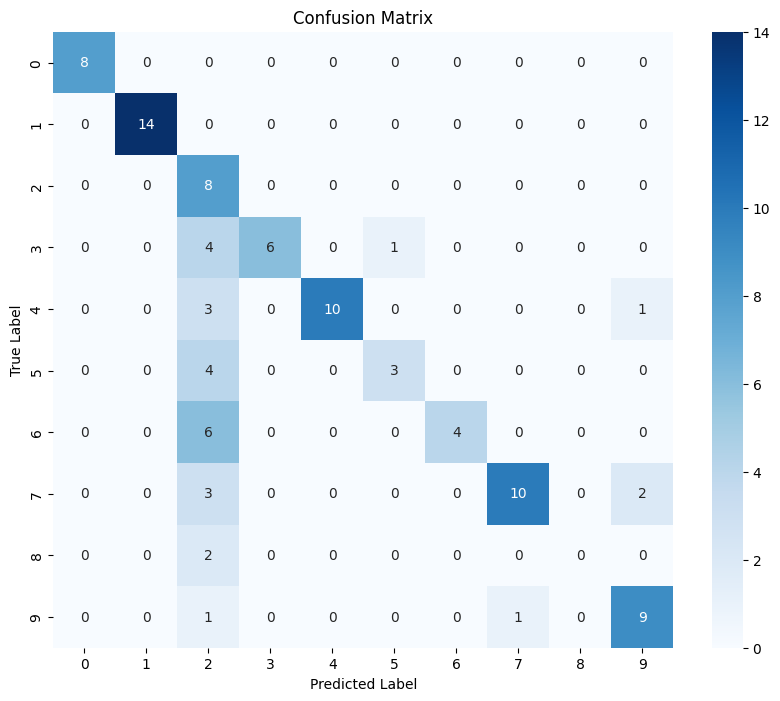

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        14
           2       0.26      1.00      0.41         8
           3       1.00      0.55      0.71        11
           4       1.00      0.71      0.83        14
           5       0.75      0.43      0.55         7
           6       1.00      0.40      0.57        10
           7       0.91      0.67      0.77        15
           8       0.00      0.00      0.00         2
           9       0.75      0.82      0.78        11

    accuracy                           0.72       100
   macro avg       0.77      0.66      0.66       100
weighted avg       0.86      0.72      0.74       100



/home/danial/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/danial/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/danial/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_test_pred, target_names=[str(i) for i in range(10)])
print("Classification Report:\n", report)

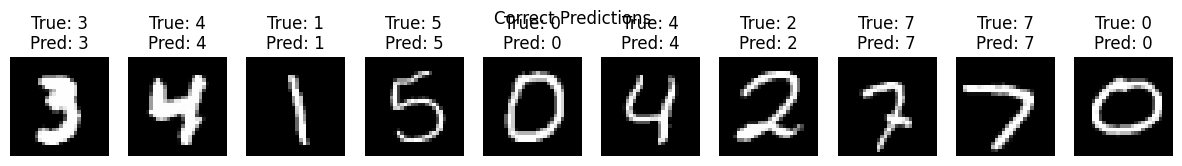

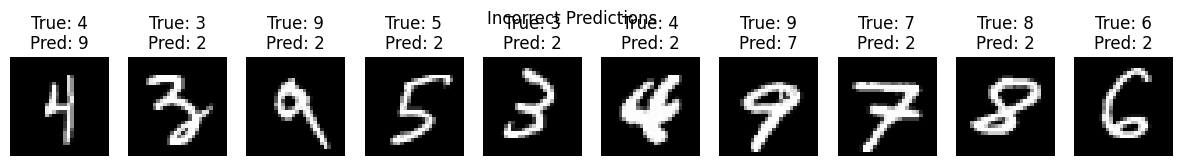

In [39]:
plot_predictions(X_test, y_test, y_test_pred, "Correct Predictions")

plot_predictions(X_test, y_test, y_test_pred, "Incorrect Predictions")